In [1]:
import pandas as pd 
import numpy as np 
from datetime import date

# Graficos 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from sklearn.preprocessing import OneHotEncoder

# Funciones

In [2]:
def tabla_frecuencias(df,col):
    #construir una tabla de frecuencias. 
    
    rating_counts = (df.groupby(col).agg(frec_absoluta=(col, "count"))).sort_values(['frec_absoluta'], ascending = False)
    
    rating_counts["frec_absoluta_acumulada"] = rating_counts["frec_absoluta"].cumsum()

    
    rating_counts['frec_relativa'] = rating_counts['frec_absoluta'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())
    rating_counts['frec_relativa(%)'] = rating_counts['frec_relativa'].apply(lambda x: x*100 )

    
    
    rating_counts['frec_relativa_acumulada'] = rating_counts['frec_absoluta_acumulada'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())  
    rating_counts['frec_relativa_acumulada(%)'] = rating_counts['frec_relativa_acumulada'].apply(lambda x: x*100)
    
    return rating_counts

In [3]:
def tabla_intervalo_frecuencias(df,col,long_intervalos):
    #construir una tabla de frecuencias. 
    aux = df
    bins = list(range(int(min(df[col])),int(max(df[col]))+1,long_intervalos))

    aux["intervalos"] = pd.cut(df[col], bins=bins)


    rating_counts = (df.groupby("intervalos").agg(frec_absoluta=(col, "count")))
    
    rating_counts["frec_absoluta_acumulada"] = rating_counts["frec_absoluta"].cumsum()

    
    rating_counts['frec_relativa'] = rating_counts['frec_absoluta'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())
    rating_counts['frec_relativa(%)'] = rating_counts['frec_relativa'].apply(lambda x: x*100 )

    
    
    rating_counts['frec_relativa_acumulada'] = rating_counts['frec_absoluta_acumulada'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())  
    rating_counts['frec_relativa_acumulada(%)'] = rating_counts['frec_relativa_acumulada'].apply(lambda x: x*100)

    
    return rating_counts

In [4]:
def conv(x):
    meses = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08',
            'septiembre':'09','octubre':'10','noviebre':'11','diciembre':'12'}
    if x == None:
        return 0
    for mes in meses:
        if mes == x:
            return meses[x]

In [5]:
def con_categ_to_columns(df,col,col_fecha):
    data = pd.DataFrame({})
    uniques = df[col].unique()
    df = df[[col_fecha,col]]
    for unique in uniques:
        aux = df[df[col] == unique]
        aux2 = (aux.groupby(col_fecha).agg(count=(col, "count"))).sort_values([col_fecha], ascending = True)
        data[unique] = aux2['count'] 
    data['fecha'] = aux2.index
    return data

In [6]:
def hora2(x):
    try:
        x = str(x)
        x1 = x[:x.index(':')+1].replace(':','.')
        x2 = x[x.index(':')+1:].replace(':','')
        x = x1 + x2
        x = float(x)
        return round(x)
        
    except:
        return '0'

In [7]:
def hora(x):
    normalizar = {12:12,1:13,2:14,3:15,4:16,5:17,6:18,7:19,8:20,9:21,10:22,11:23}
    if x == None:
        return 'DESC'
    
    else:
        x = str(x)
        try:
            x = str(x)
            x1 = x[:x.index(':')+1].replace(':','.')
            x2 = x[x.index(':')+1:].replace(':','')
            x = x1 + x2
            if 'p' in x:
                x = x.split('p')[0]
                x = float(x)
                ent = int(x)
                dec = x - ent
                x = normalizar[ent] + dec
                if 12.00 <= x and x < 19.00:
                    return 'TARDE'
                elif 19.00 <= x and x <= 23.59:
                    return 'NOCHE'
            else:
                x = x.split('a')[0]
                x = float(x)
                ent = int(x)
                dec = x - ent
                x = normalizar[ent] + dec
                if 12 <= x and x < 18.00:
                    return 'MADRUGADA'
                elif  18 <= x and x <= 23.59:
                    return 'MAÑANA'
        except:
            return '0'

# TRATAMIENTO

In [8]:
ruta_git = 'https://raw.githubusercontent.com/RiemanNClav/Hechos-de-Transito-registrados-por-la-SSC/master/hechos_transito.csv'
ruta_local = 'C:/Users/XMX5634/Documents/Hechos-de-Transito-registrados-por-la-SSC/hechos_transito.csv'
df = pd.read_csv(ruta_local)

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1823139733.py:3: DtypeWarning: Columns (4,16,17,18,19,20,32,36,41,42,43,44,45,47,49,50,51,52,53,54,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_local)


In [9]:
df.shape

(107882, 69)

In [10]:
df.isnull().sum()/len(df)*100

no_folio                  0.000927
fecha_evento              0.000000
mes                       0.000000
hora                      0.027808
condicion                67.517287
                           ...    
conductor_occiso         32.482713
conductor_lesionado      32.482713
diagnostico_occiso       98.764391
diagnostico_lesionado    33.404090
origen                   32.482713
Length: 69, dtype: float64

In [11]:
dict(zip(df.dtypes.index,df.dtypes.values))

{'no_folio': dtype('O'),
 'fecha_evento': dtype('O'),
 'mes': dtype('O'),
 'hora': dtype('O'),
 'condicion': dtype('O'),
 'tipo_de_evento': dtype('O'),
 'coordenada_x': dtype('float64'),
 'coordenada_y': dtype('float64'),
 'punto_1': dtype('O'),
 'punto_2': dtype('O'),
 'colonia': dtype('O'),
 'alcaldia': dtype('O'),
 'tipo_de_interseccion': dtype('O'),
 'tipo_de_vehiculo_1': dtype('O'),
 'tipo_de_vehiculo_2': dtype('O'),
 'tipo_de_vehiculo_3': dtype('O'),
 'marca_de_vehiculo_1': dtype('O'),
 'marca_de_vehiculo_2': dtype('O'),
 'marca_de_vehiculo_3': dtype('O'),
 'lesiones': dtype('O'),
 'edad_occiso': dtype('O'),
 'edad_lesionado': dtype('O'),
 'se_desconoce_occiso': dtype('int64'),
 'se_desconoce_lesionado': dtype('int64'),
 'total_occisos': dtype('int64'),
 'occisos_femeninos': dtype('int64'),
 'occisos_masculinos': dtype('int64'),
 'occiso_se_desconoce': dtype('int64'),
 'total_lesionados': dtype('int64'),
 'lesionados_femeninos': dtype('int64'),
 'lesionados_masculinos': dtype('in

In [12]:
dicc1 = {}
dicc2 = {}
for id_ in df.fillna({'identidad':'desconocido'}).identidad.unique():
    dicc1[id_] = len(id_.split(' '))
    dicc2[id_] = id_.split(' ')
    
print('la longitud maxima es de ' +str(len(dicc2[max(dicc1, key=dicc1.get)]))+': '+ max(dicc1, key=dicc1.get))

la longitud maxima es de 5: CONDUCTOR PASAJERO PASAJERO PASAJERO PASAJERO


In [13]:
def f_columns(df,col_name):
    dicc1 = {}
    df = df.fillna({col_name:'desconocido'})
    aux = [x.split(' ') for x in df[col_name].unique()]
    max_ = max(len(x) for x in aux)
    
    i=0
    for lista in aux:
        while len(lista) < max_:
            lista.append(None)
        dicc1[df[col_name].unique()[i]] = lista
        i+=1
        
    df['aux'] = df['identidad'].map(dicc1)
    df['len_aux'] = df['aux'].apply(lambda x: len(x))
    df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))
    
    for i in range(max_):
        df[col_name+str(i+1)] = df['aux'].apply(lambda x: x[i])

    return df[['identidad','len_identidad','aux','len_aux','identidad1','identidad2','identidad3','identidad4','identidad5']]

In [14]:
def f2_columns(df,col_name):
    dicc1 = {}
    df = df.fillna({col_name:'desconocido'})
    aux = [x.split(' ') for x in df[col_name].unique()]
    max_ = max(len(x) for x in aux)
    
    i=0
    for lista in aux:
        while len(lista) < max_:
            lista.append(None)
        dicc1[df[col_name].unique()[i]] = lista
        i+=1
        
    df['aux'] = df['identidad'].map(dicc1)
    df['len_aux'] = df['aux'].apply(lambda x: len(x))
    df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))
    
    for i in range(max_):
        df[col_name+str(i+1)] = df['aux'].apply(lambda x: x[i])

    return df

In [15]:
dicc1 = {}
df = df.fillna({'identidad':'desconocido'})
aux = [x.split(' ') for x in df['identidad'].unique()]
max_ = max(len(x) for x in aux)
    
i=0
for lista in aux:
    while len(lista) < max_:
        lista.append(None)
    dicc1[df['identidad'].unique()[i]] = lista
    i+=1
        
df['aux'] = df['identidad'].map(dicc1)
df['len_aux'] = df['aux'].apply(lambda x: len(x))
df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))

for i in range(max_):
    df['identidad'+str(i+1)] = df['aux'].apply(lambda x: x[i])

In [16]:
cases = []

### len_identidad == 1

In [17]:
len_ = 1
case = df[df['len_identidad'] == len_]

In [18]:
case["occisos_fem"] = np.where(case.occisos_femeninos > 0,case.identidad1,None)
case["occisos_masc"] = np.where(case.occisos_masculinos > 0,case.identidad1,None)
case["occisos_desc"] = np.where(case.occiso_se_desconoce > 0,case.identidad1,None)
        # ----------------------------------------------------------------------------------
case["lesionados_fem"] = np.where(case.lesionados_femeninos > 0,case.identidad1,None)
case["lesionados_masc"] = np.where(case.lesionados_masculinos > 0,case.identidad1,None)
case["lesionados_desc"] = np.where(case.lesionado_se_desconoce > 0,case.identidad1,None)

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3419861311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.where(case.occisos_femeninos > 0,case.identidad1,None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3419861311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.where(case.occisos_masculinos > 0,case.identidad1,None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3419861311.py:3: SettingWithCopyWarning: 
A value is trying to be set o

In [19]:
cases.append(case)

### len_identidad == 2

In [20]:
len_ = 2
case = df[df['len_identidad'] == len_]

In [21]:
condiciones_occisos_fem = [(case.total_occisos == 2) & (case.occisos_femeninos == len_),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 1),
                            (case.total_occisos == 1) & (case.occisos_femeninos == 1)
                           ]
elecciones_occisos_fem = np.array((case.identidad,case.identidad1,case.identidad1,), dtype="object")


condiciones_occisos_masc = [(case.total_occisos == 2) & (case.occisos_masculinos == len_),
                            (case.total_occisos == 2) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.occisos_masculinos == 1)
                           ]
elecciones_occisos_masc = np.array((case.identidad,case.identidad2,case.identidad1), dtype="object")


condiciones_occisos_desc = [(case.total_occisos == 2) & (case.occiso_se_desconoce == len_),
                   (case.total_occisos == 2) & (case.occiso_se_desconoce == 1),
                   (case.total_occisos == 1) & (case.occiso_se_desconoce == 1)
                   ]
elecciones_occisos_desc = np.array((case.identidad,case.identidad2,case.identidad1), dtype="object")

In [22]:
case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
case["occisos_desc"] = np.select(condiciones_occisos_desc, elecciones_occisos_desc, None) 

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:3: SettingWithCopyWarning: 
A value is try

In [23]:
condiciones_lesionados_fem = [(case.total_occisos == 0) & (case.lesionados_femeninos == 2),
                              (case.total_occisos == 0) & (case.lesionados_femeninos == 1),
                              (case.total_occisos == 1) & (case.lesionados_femeninos == 1),
                             ]
elecciones_lesionados_fem = np.array((case.identidad,case.identidad1,case.identidad2), dtype="object")


condiciones_lesionados_masc = [(case.total_occisos == 0) & (case.lesionados_masculinos == 2),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),
                               (case.total_occisos == 1) & (case.lesionados_masculinos == 1)
                              ]
elecciones_lesionados_masc = np.array((case.identidad,case.identidad2,case.identidad1,case.identidad2), dtype="object")


condiciones_lesionados_desc = [(case.total_occisos == 0) & (case.lesionado_se_desconoce == 2),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionado_se_desconoce == 1),
                               (case.total_occisos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                               (case.total_occisos == 1) & (case.lesionado_se_desconoce == 1),
                              ]
elecciones_lesionados_desc = np.array((case.identidad,case.identidad2,case.identidad2,case.identidad2), dtype="object")

In [24]:
case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
case["lesionados_desc"] = np.select(condiciones_lesionados_desc, elecciones_lesionados_desc, None)        

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:3: SettingWithCopyWarnin

In [25]:
cases.append(case)

### len_identidad == 3

In [26]:
len_ = 3
case = df[df['len_identidad'] == len_]

In [27]:
case['identidad1_2'] = case['identidad1'] +' '+ case['identidad2']
case['identidad2_3'] = case['identidad2'] +' '+ case['identidad3']

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1569696682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['identidad1_2'] = case['identidad1'] +' '+ case['identidad2']
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1569696682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['identidad2_3'] = case['identidad2'] +' '+ case['identidad3']


In [28]:
condiciones_occisos_fem = [(case.total_occisos == 3) & (case.occisos_femeninos == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1),
                           (case.total_occisos == 2) & (case.occisos_femeninos == 2),
                           (case.total_occisos == 2) & (case.occisos_femeninos == 1),
                           (case.total_occisos == 1) & (case.occisos_femeninos == 1)
                           ]
elecciones_occisos_fem = np.array((case.identidad,case.identidad1_2,case.identidad1,case.identidad1_2,case.identidad,case.identidad1), dtype="object")


condiciones_occisos_masc = [(case.total_occisos == 3) & (case.occisos_masculinos == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 1),                            
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 2),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 1),

                            (case.total_occisos == 2) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 2),                            
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.occisos_masculinos == 1)
                           ]
elecciones_occisos_masc = np.array((case.identidad,case.identidad3,case.identidad2,case.identidad2_3,case.identidad1,case.identidad2,case.identidad1_2,case.identidad1,case.identidad1), dtype="object")


condiciones_occisos_desc = [(case.total_occisos == 3) & (case.occiso_se_desconoce == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 1),                                                        
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 2),                            
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 2),

                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 2),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 1),                            
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.occiso_se_desconoce == 1)
                           ]
elecciones_occisos_desc = np.array((case.identidad,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad2_3,case.identidad1_2,case.identidad2,case.identidad2,case.identidad1), dtype="object")

In [29]:
case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
case["occisos_desc"] = np.select(condiciones_occisos_desc, elecciones_occisos_desc, None) 

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1727391636.py:3: SettingWithCopyWarning: 
A value is try

In [30]:
condiciones_lesionados_fem = [(case.total_occisos == 0) & (case.lesionados_femeninos == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 2),
                           (case.total_occisos == 1) & (case.lesionados_femeninos == 1),
                           (case.total_occisos == 2) & (case.lesionados_femeninos == 1),
                           ]
elecciones_lesionados_fem = np.array((case.identidad,case.identidad1,case.identidad2_3,case.identidad2,case.identidad3), dtype="object")


condiciones_lesionados_masc = [(case.total_occisos == 0) & (case.lesionados_masculinos == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 2) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 2),                            
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2),                               

                            (case.total_occisos == 1) & (case.lesionados_femeninos == 1) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),                            
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2),
                            (case.total_occisos == 2) & (case.lesionados_masculinos == 1)
                           ]
elecciones_lesionados_masc = np.array((case.identidad,case.identidad3,case.identidad2_3,case.identidad2,case.identidad,case.identidad1_2,
                                      case.identidad3,case.identidad2,case.identidad2_3,case.identidad3), dtype="object")


condiciones_lesionados_desc = [(case.total_occisos == 0) & (case.lesionado_se_desconoce == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 2) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 2),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 2),

                            (case.total_occisos == 1) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 2),
                            (case.total_occisos == 2) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                           ]
elecciones_lesionados_desc = np.array((case.identidad,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,), dtype="object")

In [31]:
case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
case["lesionados_desc"] = np.select(condiciones_lesionados_desc, elecciones_lesionados_desc, None)        

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/3320048235.py:3: SettingWithCopyWarnin

In [32]:
cases.append(case)

In [33]:
df = pd.concat(cases, axis = 0, ignore_index = True)

### len_indentidad == 4

In [ ]:
u = ['total_occisos','occisos_femeninos','occisos_masculinos','occiso_se_desconoce','total_lesionados','lesionados_femeninos',
'lesionados_masculinos','lesionado_se_desconoce','occisos_fem','occisos_masc','occisos_desc','lesionados_fem','lesionado_masc','lesionado_desc']
df[0][u].head(5)

## -----------------------------------------------------------------------------------------------------------------

In [34]:
select1 = ['no_folio','fecha_evento','mes','hora','dia','hora2','condicion','tipo_de_evento','punto_1','punto_2','colonia',
         'alcaldia','tipo_de_interseccion','tipo_de_vehiculo_1','marca_de_vehiculo_1','color_vehiculo_1','tipo_de_vehiculo_2','marca_de_vehiculo_2','color_vehiculo_2',
         'tipo_de_vehiculo_3','marca_de_vehiculo_3','color_vehiculo_3','identidad','unidad_medica_de_apoyo','hospital','prioridad',
         'observaciones','interseccion_semaforizada','clasificacion_de_la_vialidad','sentido_de_circulacion','reporte','ruta_de_transporte_publico',
           'peaton_occiso','peaton_lesionado','ciclista_occiso','ciclista_lesionado','pasajero_occiso','pasajero_lesionado','motociclista_occiso',
           'motociclista_lesionado','conductor_occiso','conductor_lesionado']
          

select2 = ['edad_occiso','se_desconoce_occiso','occisos_femeninos','occisos_masculinos','occiso_se_desconoce','total_occisos','edad_lesionado','se_desconoce_lesionado','lesionados_femeninos','lesionados_masculinos','lesionado_se_desconoce','total_lesionados',
          'occisos_fem','occisos_masc','occisos_desc','lesionados_fem','lesionados_masc','lesionados_desc']

df = df[select1+select2]

In [35]:
condiciones_fem = [(df.occisos_femeninos > 0) & (df.lesionados_femeninos > 0),
               (df.occisos_femeninos > 0) & (df.lesionados_femeninos == 0),
               (df.occisos_femeninos == 0) & (df.lesionados_femeninos > 0)
               ]
condiciones_masc = [(df.occisos_masculinos > 0) & (df.lesionados_masculinos > 0),
               (df.occisos_masculinos > 0) & (df.lesionados_masculinos == 0),
               (df.occisos_masculinos == 0) & (df.lesionados_masculinos > 0)
               ]

condiciones_desc = [(df.occiso_se_desconoce > 0) & (df.lesionado_se_desconoce > 0),
               (df.occiso_se_desconoce > 0) & (df.lesionado_se_desconoce == 0),
               (df.occiso_se_desconoce == 0) & (df.lesionado_se_desconoce > 0)
               ]

elecciones_fem = np.array(('femenino', 'femenino','femenino'), dtype="object")
elecciones_masc = np.array(('masculino', 'masculino','masculino'), dtype="object")
elecciones_desc = np.array(('desconocido', 'desconocido','desconocido'), dtype="object")

df["involucrado_fem"] = np.select(condiciones_fem, elecciones_fem, None)
df["involucrado_masc"] = np.select(condiciones_masc, elecciones_masc, None)
df["involucrado_desc"] = np.select(condiciones_desc, elecciones_desc, None)

In [36]:
edad = ['edad_occiso','se_desconoce_occiso','edad_lesionado','se_desconoce_lesionado']
fem_ = ['involucrado_fem','occisos_femeninos','lesionados_femeninos','occisos_fem','lesionados_fem']
masc_ = ['involucrado_masc','occisos_masculinos','lesionados_masculinos','occisos_masc','lesionados_masc']
desc_ = ['involucrado_desc','occiso_se_desconoce','lesionado_se_desconoce','occisos_desc','lesionados_desc']

In [37]:
rename_fem = {'involucrado_fem':'involucrado','occisos_femeninos':'total_occisos','lesionados_femeninos':'total_lesionados','occisos_fem':'occiso','lesionados_fem':'lesionado'}
rename_masc = {'involucrado_masc':'involucrado','occisos_masculinos':'total_occisos','lesionados_masculinos':'total_lesionados','occisos_masc':'occiso','lesionados_masc':'lesionado'}
rename_desc = {'involucrado_desc':'involucrado','occiso_se_desconoce':'total_occisos','lesionado_se_desconoce':'total_lesionados','occisos_desc':'occiso','lesionados_desc':'lesionado'}

fem = df[~df['involucrado_fem'].isnull()].drop(masc_+desc_ ,axis=1)[select1+fem_+edad]
masc = df[~df['involucrado_masc'].isnull()].drop(fem_+desc_ ,axis=1)[select1+masc_+edad]
desc = df[~df['involucrado_desc'].isnull()].drop(fem_+masc_ ,axis=1)[select1+desc_+edad]

fem.rename(columns = rename_fem, inplace=True)
masc.rename(columns = rename_masc, inplace=True)
desc.rename(columns = rename_desc, inplace=True)

In [38]:
df = pd.concat([fem,masc,desc], axis = 0, ignore_index = True)

In [39]:
# cuando se haga la limpieza agregar tambien estos campos
drop1 = ['peaton_occiso', 'peaton_lesionado',
       'ciclista_occiso', 'ciclista_lesionado', 'pasajero_occiso',
       'pasajero_lesionado', 'motociclista_occiso', 'motociclista_lesionado',
       'conductor_occiso', 'conductor_lesionado']

drop2 = ['edad_occiso', 'se_desconoce_occiso', 'edad_lesionado','se_desconoce_lesionado']



#borrar definitivamente desde el inicio
# observaciones: trata de ver como poder etiquetar dichos comentarios
drop_inicio = ['condicion','tipo_de_vehiculo_3','marca_de_vehiculo_3','color_vehiculo_3','ruta_de_transporte_publico','ruta_de_transporte_publico','reporte','hospital','observaciones']

In [40]:
df.sort_values(["no_folio", "fecha_evento"], inplace=True)
df = df.drop(drop1+drop2+drop_inicio,axis=1)

In [41]:
df = df.fillna({'marca_de_vehiculo_1':'desconocido','occiso':'desconocido','interseccion_semaforizada':'desconocido','lesionado':'desconocido',
               'clasificacion_de_la_vialidad':'desconocido','sentido_de_circulacion':'desconocido','color_vehiculo_2':'desconocido',
               'marca_de_vehiculo_2':'desconocido','tipo_de_vehiculo_2':'desconocido','tipo_de_vehiculo_2':'desconocido','color_vehiculo_1':'desconocido'})

In [42]:
df['year'] = pd.to_datetime(df['fecha_evento']).dt.to_period('Y')

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_3968/1187084835.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['year'] = pd.to_datetime(df['fecha_evento']).dt.to_period('Y')


In [43]:
#fechas = df['year'].astype(str) + "-" + df['num_mes'] + "-" + '01'
#df['fecha_mensual'] = pd.to_datetime(fechas)

KeyError: 'num_mes'

In [44]:
df['parte_dia'] = df['hora'].apply(lambda x: hora(x))

In [45]:
df = df[df["parte_dia"].isin(["MAÑANA", "TARDE",'NOCHE','MADRUGADA'])]

In [51]:
# borrar def al final 
drop_final = ['no_folio','fecha_evento','hora','mes','parte_dia','punto_1','punto_2']
df = df.drop(drop_final,axis=1)

In [52]:
(df.isnull().sum()/len(df))*100

hora2                           0.000000
tipo_de_evento                  0.000000
punto_1                         0.000000
punto_2                         0.000000
colonia                         0.000000
alcaldia                        0.000000
tipo_de_interseccion            0.000000
tipo_de_vehiculo_1              0.000000
marca_de_vehiculo_1             0.000000
color_vehiculo_1                0.000000
tipo_de_vehiculo_2              0.000000
marca_de_vehiculo_2             0.000000
color_vehiculo_2                0.000000
identidad                       0.000000
unidad_medica_de_apoyo          0.001032
prioridad                       0.000000
interseccion_semaforizada       0.000000
clasificacion_de_la_vialidad    0.000000
sentido_de_circulacion          0.000000
involucrado                     0.000000
total_occisos                   0.000000
total_lesionados                0.000000
occiso                          0.000000
lesionado                       0.000000
year            

### Limpieza de las variables que se seleccionaron 

In [48]:
# limpieza del la variable dia. 
dias = [value.upper() for value in df.dia.unique() if value.upper() in ['LUNES','MARTES','MIERCOLES','JUEVES','VIERNES','SABADO','DOMINGO']]
df['dia_aux'] = df['dia'].apply(lambda x:x.upper())
df = df[df['dia_aux'].isin(dias)].drop(['dia'],axis=1)
df.rename(columns = {'dia_aux': 'dia'},inplace=True)

(array([68474.,   939.,  1271.,  4897.,  2877.,  3086.,  5281.,  3220.,
         3171.,  3728.]),
 array([    0.,  8280., 16560., 24840., 33120., 41400., 49680., 57960.,
        66240., 74520., 82800.]),
 <BarContainer object of 10 artists>)

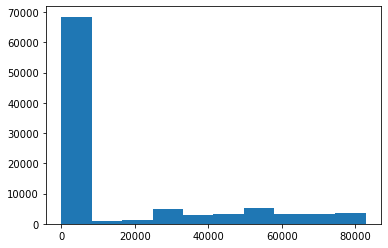

In [53]:
#sesgos de la variable hora2
plt.hist(df.hora2)

In [61]:
#limpieza de la variable hora2
#quitaremos los sesgos de las horas, nos quedaremos con aquellas horas de 24. 
df = df[df['hora2'].isin([i for i in range(1,24)])]
df.rename({'hora2': 'hora'}, inplace=True)

In [64]:
df

,hora2,tipo_de_evento,punto_1,punto_2,colonia,alcaldia,tipo_de_interseccion,tipo_de_vehiculo_1,marca_de_vehiculo_1,color_vehiculo_1,...,interseccion_semaforizada,clasificacion_de_la_vialidad,sentido_de_circulacion,involucrado,total_occisos,total_lesionados,occiso,lesionado,year,dia
60356,4.0,ATROPELLADO,EJE 2 SUR,TOPACIO,PAULINO NAVARRO,CUAUHTEMOC,CRUZ,SD,SD,desconocido,...,desconocido,desconocido,desconocido,masculino,0,1,desconocido,PEATON,2018,DOMINGO
50703,7.0,CHOQUE,EJE 5 PTE,POSTES,JOSE MA PINO SUAREZ,ALVARO OBREGON,Y,AUTOMOVIL,GOLF,desconocido,...,desconocido,desconocido,desconocido,masculino,0,1,desconocido,MOTOCICLISTA,2019,MARTES
7181,8.0,ATROPELLADO,CALZ DE GUADALUPE,EJE 3 NTE,GUADALUPE TEPEYAC,GUSTAVO A MADERO,CRUZ,TAXI,TSURU,desconocido,...,desconocido,desconocido,desconocido,femenino,0,1,desconocido,PEATON,2019,MARTES
7182,8.0,ATROPELLADO,HIDALGO,AV VASCO DE QUIROGA,STA FE,ALVARO OBREGON,T,AUTOMOVIL,TSURU,desconocido,...,desconocido,desconocido,desconocido,femenino,0,1,desconocido,PEATON,2019,MARTES
61063,8.0,ATROPELLADO,EJE 8 SUR,AV JALISCO,ZACATEPEC,IZTAPALAPA,T,AUTOMOVIL,SD,desconocido,...,desconocido,desconocido,desconocido,masculino,0,1,desconocido,PEATON,2019,MARTES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60492,10.0,CHOQUE,NICOLAS CATALAN,ANILLO PERIFERICO,SAN JUAN JOYA,IZTAPALAPA,T,AUTOMOVIL,POINTER,desconocido,...,desconocido,desconocido,desconocido,masculino,0,1,desconocido,PASAJERO,2018,LUNES
82740,4.0,ATROPELLADO,CIRCUITO BICENTENARIO,CALZ GRAL IGNACIO ZARAGOZA,STA CRUZ AVIACION,VENUSTIANO CARRANZA,CRUZ,AUTOMOVIL,BEAT,BLANCO,...,SI,VAC ANULAR,S-N,masculino,1,0,desconocido,desconocido,2021,VIERNES
82475,14.0,CHOQUE,AV TLAHUAC,LUIS DELGADO,SANTIAGO CENTRO,TLAHUAC,T,MOTOCICLETA,SD,SD,...,NO,VIA PRIMARIA,SP-NO,masculino,0,1,desconocido,desconocido,2021,VIERNES
71077,8.0,CHOQUE,AV UNIVERSIDAD,AV GRAL ANTONIO LEON LOYOLA,EJERCITO CONSTITUCIONALISTA,IZTAPALAPA,T,MOTOCICLETA,SD,SD,...,SI,VIA SECUNDARIA,O-P,masculino,0,2,desconocido,desconocido,2020,VIERNES


# EXPLORACION DE DATOS

In [ ]:
tabla_frecuencias(df,'parte_dia')

In [ ]:
pareto(df,'intervalos','Horas en las que ocurren eventos en CDMX')

In [ ]:
u = con_categ_to_columns(df,'parte_dia','fecha_mensual')

In [ ]:
fig = px.line(u, x='fecha', y=u.columns,
              hover_data={"fecha": "|%B %d, %Y"},
              title='Histórico del comportamiento de los sucesos en las 4 partes del dia',
             width=1300, height=400)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Se puede observar que de manera general hay una distribución muy homogenea de como se comportan los eventos por hora, desde las 7am hasta las 21 pm, conforme las horas van pasando, van decreciendo los eventos.

por las madrugradas es cuando menos accidentes ocurren entre la 1 y 7 am, suelen ser bajos los sucesos activos. 

De manera histórica suelen haber mas accidentes por las tardes, su comportamiento es muy homogeneo tambíen, aunque en el ultimo trimestre del 2022 hubo una alza en las 4 partes del dia, a comparación de otros periodos. 

In [ ]:
u = con_categ_to_columns(df,'tipo_de_evento','fecha_mensual')

In [ ]:
fig = px.line(u, x='fecha', y=u.columns,
              hover_data={"fecha": "|%B %d, %Y"},
              title='Histórico de los eventos ocurridos en CDMX, de manera mensual.',
             width=1300, height=400)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Se observa que por encima de todos, los CHOQUES ocurren en mayor medida, cada uno de los eventos ha seguido las mismas tendencias, con pequeñas excepciones donde hay pequeños o grandes aumentos.

Se destaca que los CHOQUES ocurrieron en mayor proporción en el último trimestre del 2022 respecto a su histórico, pero no es un comportamiento ciclico, en años anteriores en el mismo trimestre nunca se había visto este aumento tan significativo, los DERRAPOS y los ATROPPELLOS también tuvieron un comportamiento similar en este último trimestre del 2022. 

Será interesante analizar este último trimestre y ver las razones del porque estan ocurriendo mas los eventos.

In [ ]:
aux1 = pd.DataFrame(df.groupby(['year','mes'])['tipo_de_evento'].count()).reset_index()

In [ ]:
tabla_frecuencias(df,'tipo_de_evento')

Se observa que el 90% de los accidentes de tránsito que ocurren en la CDMX son por causas como CHOQUES, ATROPELLOS Y DERRAPOS, en donde el 56% son provocados por CHOQUES. 

Valdria la pena revisar estas tres categorías por separado y las ultimas 3 en conjunto (CAIDA DE CICLISTA, VOLCADURA Y CAIDA DE PASAJERO) ya que aproximadamente el 5% del total, son accidentes de este estilo. 

## Análisis Urbano
### de lo general a lo particular

In [ ]:
aux = pd.DataFrame(df.groupby(['alcaldia','tipo_de_evento'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_occisos',hue='tipo_de_evento',data=aux.sort_values('total_occisos', ascending = False))

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_lesionados',hue='tipo_de_evento', data=aux.sort_values('total_lesionados', ascending = False))

In [ ]:
aux = pd.DataFrame(df.groupby(['alcaldia','involucrado','tipo_de_evento'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_occisos',hue='involucrado',data=aux.sort_values('total_occisos', ascending = False))

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_lesionados',hue='involucrado',data=aux.sort_values('total_lesionados', ascending = False))

Analisis:

Lesionados:
* Cuauhtemoc, Iztapalapa y Gustavo A. Madero las alcaldias que mas lesiones presentan.
* De manera general en todas alcaldias, ocurren mas las lesiones por CHOQUES.
* Atropellos y Derrapos suelen ocurrir con la misma frecuencia. 
* Caida de Ciclista,Volcadura y Caida de Pasajero ocurren de igual manera con la misma frecuencia y en menores proporciones
* Suelen lesionarse mas Hombres que Mujeres en todas las alcaldias. 

Muertos:
* Tlalpan, Iztapalapa y Gustavo A. Madero las alcaldias que mas muertes presentan.
* Las muertes por atropellos sobrepasan en Venustiano Carranza e Iztacalco.
* Suelen morir mas Hombres que Mujeres en todas las alcaldias.

**target 1 = ¿Cuales son las condiciones en las que mueren y se lesionan mas los Hombres por choques en Iztapalapa, Gustavo A.Madero, Tlalpan y Cuauhtemoc?**

**target 2 = ¿Cuales son las condiciones por las que mueren mas Hombres atropellados en Venustiando Carranza e Iztacalco?**

In [ ]:
targ_1 = df[(df['involucrado'] == 'masculino') & (df['tipo_de_evento'] == 'CHOQUE') & (df['alcaldia'].isin(['GUSTAVO A MADERO','TLALPAN','CUAUHTEMOC','IZTAPALAPA'])) ]

In [ ]:
aux = pd.DataFrame(targ_1.groupby(['alcaldia','colonia'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
lesionados_ = []
occisos_ = []
for alc in aux.alcaldia.unique():
    lesionados = aux[aux['alcaldia'] == alc][['alcaldia','colonia','total_lesionados']].sort_values('total_lesionados', ascending = False)
    les = lesionados.iloc[0:10,:]
    occisos = aux[aux['alcaldia'] == alc][['alcaldia','colonia','total_occisos']].sort_values('total_occisos', ascending = False)
    occs = occisos.iloc[0:10,:]
    lesionados_.append(les)
    occisos_.append(occs)
    
df_les = pd.concat(lesionados_, axis = 0, ignore_index = True).sort_values('total_lesionados')
df_occi = pd.concat(occisos_, axis = 0, ignore_index = True).sort_values('total_occisos')

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x='total_lesionados', y='colonia', data = df_les, color='red')

* Juan Escutia, Roma Sur, Leyes de Reforma 3a Secc, Sta Maria la Ribera, Guerrero, Obrera, Roma Nte, Doctores y Centro son todas colonias donde los hombres se lesionan mas por CHOQUES > 200.

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x='total_occisos', y='colonia', data = df_occi, color='black')

* Leyes de Reforma 3a Seccion, El Paraiso, Morelos, San Felipe de Jesus, Juan Escutia, Area Fed Central de Abastos, San Andres Totoltepec, San Miguel Topilejo, Centro, Rusticia Tlalpan y Doctores son las colonias en donde mas hombres mueren  a causa de un choque > 5. 

In [ ]:

aux = pd.DataFrame(targ_1.groupby(['colonia','year','parte_dia'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
aux

# PREPROCESAMIENTO DE DATOS

In [ ]:
# borrar def al final 
drop_final = ['fecha_mensual','parte_dia']
df = df.drop(drop_final,axis=1)

In [ ]:
df_dummies = pd.get_dummies(df,columns=['punto_1','punto_2','colonia','identidad','unidad_medica_de_apoyo','interseccion_semaforizada','tipo_de_evento','prioridad','alcaldia','tipo_de_interseccion','clasificacion_de_la_vialidad','sentido_de_circulacion','involucrado','occiso','lesionado','tipo_de_vehiculo_1','tipo_de_vehiculo_2','marca_de_vehiculo_1','marca_de_vehiculo_2','color_vehiculo_1','color_vehiculo_2'])

### FEATURE SELECTION

In [ ]:
df.columns

In [ ]:
# limpieza del la variable dia. 
dias = [value.upper() for value in df.dia.unique() if value.upper() in ['LUNES','MARTES','MIERCOLES','JUEVES','VIERNES','SABADO','DOMINGO']]
df['dia_aux'] = df['dia'].apply(lambda x:x.upper())
aux = df[df['dia_aux'].isin(dias)].drop(['dia'],axis=1)
aux.rename(columns = {'dia_aux': 'dia'},inplace=True)

In [ ]:
#limpieza de la variable hora2

In [ ]:
#quitaremos los sesgos de las horas, nos quedaremos con aquellas horas de 24. 
df = df[df['hora2'].isin([i for i in range(1,24)])]

In [ ]:
plt.hist(df.hora2)

In [ ]:
#limpieza de la variable punto_1 y punto_2

In [ ]:
print(len([x.replace(' ','') for x in df.punto_1.unique()]))
print(len([x.replace(' ','') for x in df.punto_2.unique()]))

In [ ]:
df['punto_1_aux']= df['punto_1'].apply(lambda x: x.replace(' ','')).drop(['punto_1'],axis=1)
df['punto_2_aux']= df['punto_2'].apply(lambda x: x.replace(' ','')).drop(['punto_1'],axis=1)
df.rename(columns = {'punto_1_aux': 'punto_1','punto_2_aux':'punto_2'},inplace=True)

In [ ]:
print(len(df.punto_1_aux.unique()))
print(len(df.punto_2_aux.unique()))


In [ ]:
len(df.marca_de_vehiculo_1.unique())